# Gate Semantic Segmentation for Drone Racing based on Fully Convolutional Neural Networks (FCN)

In [ ]:
import os
import time
import torch
import torch.nn as nn
from torchsummary import summary
from torchvision import transforms, utils
from torch.utils.data import Dataset, DataLoader
from collections import OrderedDict
from skimage import io, transform
import matplotlib.pyplot as plt
from google.colab import drive
import pandas as pd
import numpy as np

# mount project dir
drive.mount('/content/gdrive')
# !ls '/content/gdrive/My Drive/'
PATH = '/content/gdrive/MyDrive/'
PROJECT_PATH = PATH + 'LR Research/Coding/gate-detection-FCN/'
GATE_PATH = PATH + 'TU Delft/Brightspace Courses/AE4317/Washington_OB_Race/Gate_Imgs/'

Mounted at /content/gdrive


## 1. Data Preprocessing

### 1.1 Organize Data and Build Datasets for Training and Test

Categorize images and masks into 2 sets for training and evaluation respectively. There are 308 images and 308 masks in total and 280 images/masks are set to training set. The rest of the images are categorized into test set.

In [ ]:
class DataOrganizer():
    def __init__(self, root_dir):
        self.root_dir = root_dir

        self.gate_img_names = []
        self.gate_mask_names = []

        # 280 images and masks for training
        self.size_train = 280

        # read all img and masks
        for root, dirs, files in os.walk(self.root_dir):
            for id, filename in enumerate(files):
                if filename[:4] == 'img_':
                    self.gate_img_names.append(filename)
                    self.gate_mask_names.append('mask_' + filename[4:])
        # divide into train and test subsets
        self.img_train = self.gate_img_names[0:self.size_train]
        self.img_test = self.gate_img_names[self.size_train:len(self.gate_img_names)]

        self.mask_train = self.gate_mask_names[0:self.size_train]
        self.mask_test = self.gate_mask_names[self.size_train:len(self.gate_mask_names)]

        assert len(self.gate_mask_names) == len(self.gate_img_names) and \
               len(self.img_train) == len(self.mask_train) and \
               len(self.img_test) == len(self.mask_test), "Number of masks and imgs need to be the same"

        print('Dataset for drone racing initialized: {} are set to the training set and {} are set to the test set.\n' \
              .format(len(self.img_train), len(self.img_test)))


class GateDataset(Dataset):
    def __init__(self, data, is_train, transform):
        self.data = data
        self.is_train = is_train
        self.transform = transform

        if self.is_train:
            self.img_names = self.data.img_train
            self.mask_names = self.data.mask_train
        else:
            self.img_names = self.data.img_test
            self.mask_names = self.data.mask_test

    def __len__(self):
        return len(self.img_names)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # read as np.ndarray
        img = io.imread(os.path.join(self.data.root_dir, self.img_names[idx]))
        mask = io.imread(os.path.join(self.data.root_dir, self.mask_names[idx]))

        sample = {'img': img, 'mask': mask}
        
        if self.transform:
            sample = self.transform(sample)

        return sample

organized_data = DataOrganizer(GATE_PATH)

Dataset for drone racing initialized: 280 are set to the training set and 28 are set to the test set.



### 1.2 Apply Transforms

Before feeding the data into the neural network, `Transforms` are essential to set datasize and transform the datatype to *tensor*.

One issue can be observed from the dataset is that not all samples are of the same size. Specifically, 275 images and 275 masks have a size of `360x360`. In deep learning, people scale images to make them fit the input shape of the neural network. Moreover, *semantic segmentation* tasks would require re-mapping the predicted pixel categories back to the original-size input image. It would be very difficult to do this precisely, especially in segmented regions with different semantics. To avoid this problem, instead of rescaling, images are cropped to set dimensions. Random-cropping is used to set all images and masks to the same size. This can also be considered as data augmentation.

#### 1.2.1 Define Transforms

Concretely, two `Transforms` were used in this project:

+ `RandomCrop`: to crop from image randomly to set all images and mask to be the same size.
+ `ToTensor`: to convert the numpy images to torch images (to swap axes).

In [ ]:
class RandomCrop():
    """Crop randomly the image in a sample"""
    def __init__(self, output_size):
        """
        Args:
            output_size (tuple or int): Desired output size. if int,
            square crop is made.
        """
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2, "Output size error: has to be 2-dimentional"
            self.output_size = output_size
    
    def __call__(self, sample):
        image, mask = sample['img'], sample['mask']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size
        # top left corner coordinate of the cropped sample
        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        cropped_image = image[top: top + new_h, left: left + new_w]
        cropped_mask = mask[top: top + new_h, left: left + new_w]

        return {'img': cropped_image, 'mask': cropped_mask}


class ToTensor():
    """Convert ndarrays in sample to Tensors."""
    def __call__(self, sample):
        img, mask = sample['img'], sample['mask']

        # numpy image: H x W x C; torch image: C x H x W
        to_tensor = transforms.ToTensor()
        img = to_tensor(img).float()
        #mask = torch.as_tensor(mask / 255).unsqueeze(0)
        mask = to_tensor(mask)
        return {'img': img, 'mask': mask}

#### 1.2.2 Compose Transforms and Initialize Datasets

In [ ]:
new_hw = 288
print("Data cropped to new width and height: {}x{}\n".format(new_hw, new_hw))

train_set = GateDataset(data=organized_data,
                        is_train=True,
                        transform=transforms.Compose([RandomCrop(new_hw), ToTensor()]))

test_set = GateDataset(data=organized_data,
                        is_train=False,
                        transform=transforms.Compose([RandomCrop(new_hw), ToTensor()]))

Data cropped to new width and height: 288x288



The new height and width of the image is set to be `288` for several reasons:
1. It can be calculated from the dataset that the minimum image height/width is `315`, the cropped image size is supposed to be smaller than it to make sure `RandomCrop` can be done correctly.
2. In Section 2, `max-pooling` is used in FCN model to merge semantically similar features into one, reducing the dimension of the representation and creating an invariance to small shifts and distortions. Each `max-pooling` layer divide the size of feature map by `2` and there are overall 5 `max-pooling` layers. `288` is the maximum number which is not only smaller than `315` but also can be divided by `2` five times with no remainder.

Now both the training and test datasets are ready to go. To summarize, everytime this dataset is sampled: (1) A gate image and mask corresponding to it is read from the file on the fly; (2) `Transforms` (`RandomCrop` & `ToTensor`) are applied on the read image.

### 1.3 Iterating Through The Dataset by Using `DataLoader`

+ Batching the data with `batch_size=16` for training set and `batch_size = 4` for test set.
+ Shuffling the data.

In [ ]:
train_loader = DataLoader(train_set, batch_size=16, shuffle=True)
test_loader = DataLoader(test_set, batch_size=4, shuffle=True)

## 2. Fully Convolutional Neural Network (FCN) Models



### 2.1 Build VGG-based Neural Network to Extract Gate Features

There are 3 overall strucutures for `MiniVGG` model. `vgg-11` is adapted from the original VGG paper, with only the final fully connected layers being discarded and replaced by transposed convolutional layers to reconstruct the orignal image size. `vgg-5` is a smaller version of `vgg-11` by omitting several convolutional layers to decrease memory storage and possibly increase inference speed. It can be found in evaluation tests that `vgg-5` and `vgg-11` both perform very well on the gate semantic segmentation task, while `vgg-5` can operate at a higher speed. `BatchNorm` is also added for ablation experiments.

In [ ]:
class MiniVGG(nn.Module):
    def __init__(self, config, batch_norm, in_channels=3):
        super(MiniVGG, self).__init__()
        self.config = config
        self.bn_enabled = batch_norm
        self.in_channels = in_channels
        
        # initialize self.blocks as ModuleList so the blocks can be properly registered
        self.blocks = nn.ModuleList()
        assert self.config in ['vgg-5', 'vgg-11'], 'Invalid config: only support \'vgg-5\' or \'vgg-11\''

        if self.config == 'vgg-5':
            self.net_arch = [[64, 'M', 128, 'M'], [256, 'M'], [512, 'M'], [512, 'M']]
        else:
            self.net_arch = [[64, 'M', 128, 'M'], [256, 256, 'M'], [512, 512, 'M'], [512, 512, 'M']]
        
        for block in self.net_arch:
            # connect each layer inside each block
            self.layers = []
            for id, layer in enumerate(block):
                if layer == 'M':
                    self.layers.append(('maxpool({})'.format(id),
                                        nn.MaxPool2d(kernel_size=2, stride=2)))
                else:
                    self.layers.append(('conv2d({})'.format(id),
                                        nn.Conv2d(self.in_channels, layer, kernel_size=3, stride=1, padding=1)))
                    self.layers.append(('relu({})'.format(id),
                                        nn.ReLU(inplace=True))) # set inplace to save memory
                    if self.bn_enabled:
                        self.layers.append(('bn({})'.format(id),
                                            nn.BatchNorm2d(layer)))
                    self.in_channels = layer
            
            # add to modulelist
            self.blocks.append(nn.Sequential(OrderedDict(self.layers)))


    def forward(self, x):
        for block in self.blocks:
            x = block(x)
        return x

### 2.2 Transposed Convolutional Layers for Upsampling and Skip-Layer Structures

The final FCN model is built on `MiniVGG` by adding transposed convolutional layers for upsampling. These layers are initialized with bilinear interpolation with the parameters allowed to be learned. There are overall 3 upsampling structures, 2 of those connect fine feature layers with coarse ones in a skip-layer manner. To make the linear transformation between layers with different number of feature maps possible, `1x1` convolution is introduced for channel reduction.

In [ ]:
class FCN(nn.Module):
    def __init__(self, model, upsample_mode):
        super(FCN, self).__init__()
        self.vgg = model
        self.upsample_mode = upsample_mode
        self.num_classes = 1

        assert self.upsample_mode in ['32s', '16s', '8s'], 'Invalid upsampling: only support \'32s\', \'16s\' or \'8s\''
        
        # upsampling layers
        self.unconv8x  = nn.ConvTranspose2d(self.num_classes, self.num_classes,
                                            kernel_size=16, stride=8,  padding=4,  bias=False)
        self.unconv16x = nn.ConvTranspose2d(self.num_classes, self.num_classes,
                                            kernel_size=32, stride=16, padding=8,  bias=False)
        self.unconv32x = nn.ConvTranspose2d(self.num_classes, self.num_classes,
                                            kernel_size=64, stride=32, padding=16, bias=False)
        self.unconv2x_pool3 = nn.ConvTranspose2d(self.num_classes, self.num_classes,
                                                 kernel_size=4,  stride=2,  padding=1,  bias=False)
        self.unconv2x_pool5 = nn.ConvTranspose2d(self.num_classes, self.num_classes,
                                                 kernel_size=4,  stride=2,  padding=1,  bias=False)
        
        # 1x1 convolution layers for dimension/channel reduction
        self.linear_conv_pool3 = nn.Conv2d(256, 1, kernel_size=1)
        self.linear_conv_pool4 = nn.Conv2d(512, 1, kernel_size=1)
        self.linear_conv_pool5 = nn.Conv2d(512, 1, kernel_size=1)
        
        # initializing the transposed convolution layer with bilinear interpolation, and make it learnable
        for m in self.modules():
            if isinstance(m, nn.ConvTranspose2d):
                m.weight.data.copy_(self.get_upsampling_weight(m.in_channels, m.out_channels, m.kernel_size[0]))
    

    def get_upsampling_weight(self, in_channels, out_channels, kernel_size):
        # make a 2D bilinear kernel suitable for upsampling
        factor = (kernel_size + 1) // 2
        center = factor - 1 if kernel_size % 2 == 1 else factor - 0.5
        og = np.ogrid[:kernel_size, :kernel_size]
        filt = (1 - abs(og[0] - center) / factor) * (1 - abs(og[1] - center) / factor)
        
        weight = np.zeros((in_channels, out_channels, kernel_size, kernel_size), dtype=np.float64)
        weight[range(in_channels), range(out_channels), :, :] = filt
        
        return torch.from_numpy(weight).float()


    def forward(self, x):
        pool2 = self.vgg.blocks[0](x) # block[1] has 2 max-pooling layers
        pool3 = self.vgg.blocks[1](pool2)
        pool4 = self.vgg.blocks[2](pool3)
        pool5 = self.vgg.blocks[3](pool4)

        if self.upsample_mode == '32s':
            out = self.unconv32x(self.linear_conv_pool5(pool5))

        elif self.upsample_mode == '16s':
            upsample_2x = self.unconv2x_pool5(self.linear_conv_pool5(pool5)) + self.linear_conv_pool4(pool4)
            out = self.unconv16x(upsample_2x)

        elif self.upsample_mode == '8s':
            upsample_2x = self.unconv2x_pool5(self.linear_conv_pool5(pool5)) + self.linear_conv_pool4(pool4)
            upsample_4x = self.unconv2x_pool3(upsample_2x) + self.linear_conv_pool3(pool3)
            out = self.unconv8x(upsample_4x)

        return out

## 3. Training and Evaluation Results

The gate semantic segmentation consists of firstly training the neural network model with variant architectures (`vgg-5` with `8s` etc.) and then implementing evaluation experiemnts like inference speed estimation and prediction accuracy comparison for trained models. `Binary Cross Entropy (BCE)` is chosen to be the loss function for this task since it is a two-class classification task for every pixel. `Adam` optimizer is used to update the parameters of the neural network.

In [ ]:
class GateDetection():
    def __init__(self, vgg_config, upsample_mode, batch_norm, num_epoch, 
                 train_set, test_set, train_loader, test_loader, print_summary=False, pretrained=False):
        self.vgg_config = vgg_config
        self.upsample_mode = upsample_mode
        self.batch_norm = batch_norm
        self.num_epoch = num_epoch
        self.train_set = train_set
        self.test_set = test_set
        self.train_loader = train_loader
        self.test_loader = test_loader

        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.mini_vgg = MiniVGG(self.vgg_config, self.batch_norm)
        self.fcn_model = FCN(self.mini_vgg, self.upsample_mode).to(self.device)
        # binary cross entropy loss function
        self.criterion = nn.BCEWithLogitsLoss().to(self.device)

        self.pretrained_model_path = os.path.join(PROJECT_PATH,
                                                  "pretrained_models/{}_{}_bn_{}".format(self.vgg_config,
                                                                                         self.upsample_mode,
                                                                                         str(self.batch_norm)))

        if print_summary:
            summary(self.fcn_model, (3, 288, 288))

        if pretrained:
            assert os.path.exists(self.pretrained_model_path), "pretrained model directory does not exist"
            self.fcn_model.load_state_dict(torch.load(os.path.join(self.pretrained_model_path,
                                                                   "epoch_{}.pt".format(self.num_epoch)),
                                            map_location=torch.device(self.device)))
                

    def train(self):
        """
        Train the FCN model with given structure.
        After training, save trained model & logger for loss.
        """
        # loss logger and pretrained model directory
        logger_train = open(PROJECT_PATH + "logs/loss_{}_{}_bn_{}.txt".format(self.vgg_config,
                                                                              self.upsample_mode,
                                                                              str(self.batch_norm)), "w+")
        if not os.path.exists(self.pretrained_model_path):
            os.mkdir(self.pretrained_model_path)

        optimizer = torch.optim.Adam(self.fcn_model.parameters(), lr=1e-4)

        # training process
        start_time = time.time()
        for epoch_idx in range(self.num_epoch + 1):
            for iter, batch in enumerate(self.train_loader):
                optimizer.zero_grad()
                inputs = batch['img'].to(self.device)
                labels = batch['mask'].to(self.device)
                loss = self.criterion(self.fcn_model(inputs), labels)
                loss.backward()
                optimizer.step()

            # print and store loss for each epoch
            print("epoch{}, loss: {}".format(epoch_idx, loss.data))
            logger_train.write("{}, {}\n".format(epoch_idx, loss.data))
            logger_train.flush()

            # save trained model every 200 epochs
            if epoch_idx % 200 == 0:
                torch.save(self.fcn_model.state_dict(),
                           os.path.join(self.pretrained_model_path,
                                        "epoch_{}.pt".format(epoch_idx)))
        end_time = time.time()

        logger_train.close()
        print("Finished training, took %.2f seconds\n" % (end_time - start_time))


    def demo_show(self, apply_sigmoid=False):
        """
        Demonstrate the original image & ground truth & prediction
        on several samples randomly sampled from training/test datasets.
        """
        # plot images and masks
        num_of_subs = 6
        train_seed = np.random.randint(low=1, high=len(train_set), size=int(num_of_subs / 2))
        test_seed = np.random.randint(low=1, high=len(test_set), size=int(num_of_subs / 2))
        sample_seed = np.concatenate((train_seed, test_seed))

        fig = plt.figure(dpi=200)
        fig.tight_layout()
        plt.subplots_adjust(bottom=0.0, top=0.6)
        
        for id, i in enumerate(sample_seed):
            train_or_test = 'train' if id < 3 else 'test'
            sample = self.train_set[i] if id < 3 else self.test_set[i]

            # show img
            ax1 = plt.subplot(3, num_of_subs, id + 1)
            ax1.set_title('{} img #{}'.format(train_or_test, i), fontsize=4)
            ax1.axis('off')
            ax1.imshow(sample['img'].numpy().transpose(1, 2, 0))

            # show mask
            ax2 = plt.subplot(3, num_of_subs, id + num_of_subs + 1)
            ax2.set_title('{} mask #{}'.format(train_or_test, i), fontsize=4)
            ax2.axis('off')
            ax2.imshow(sample['mask'].numpy().squeeze(0), cmap='gist_gray')

            # show output
            ax3 = plt.subplot(3, num_of_subs, id + 2 * num_of_subs + 1)
            ax3.set_title('{} prediction #{}'.format(train_or_test, i), fontsize=4)
            ax3.axis('off')

            output = self.fcn_model(sample['img'].to(self.device).unsqueeze(0))
            if apply_sigmoid == True:
                output = torch.sigmoid(output)
            
            # host tensor memory on cpu before transfer to cuda
            ax3.imshow(output.detach().cpu().numpy().reshape(288,288), cmap='hot')


    def compute_IoU_PixelAccuracy(self):
        """
        Calculate the mean Intersaction of Unions (IoU) and Pixel Accuracy of given model on test dataset.
        Mean IoU: true_positive / (true_positive + false_positive + false_negative)
        Pixel Acc.: (number of pixels of class i predicted to belong to class i) / (total number of pixels of class i)
        """
        iou_score = 0
        pixel_acc = 0

        for iter, batch in enumerate(test_loader):
            inputs = batch['img'].to(self.device)
            labels = batch['mask'].to(self.device)

            logits = self.fcn_model(inputs)
            y_pred = torch.sigmoid(logits).detach().cpu().numpy()
            y_true = labels.cpu().numpy()

            intersection = np.logical_and(np.rint(y_true), np.rint(y_pred))
            union = np.logical_or(np.rint(y_true), np.rint(y_pred))
            iou_score += np.sum(intersection) / np.sum(union)
            pixel_acc += np.sum(intersection) / np.sum(np.rint(y_true))
        
        return {'IoU':iou_score / len(test_loader), 'PA':pixel_acc / len(test_loader)}
    

    def inference_speed(self):
        """
        Evaluate the mean inference speed of the model on GPU over the training dataset.
        """
        total_time = 0
        for i in range(len(self.test_set)):
            sample = self.test_set[i]
            start_eval = time.time()
            output = self.fcn_model(sample['img'].to(self.device).unsqueeze(0))
            end_eval = time.time()
            total_time += end_eval - start_eval
        
        # inference speed is evaluated in miliseconds
        return 1000 * total_time / len(self.test_set)

### 3.1 Training Process

In the training process, 9 independent experiements are executed, including `vgg-5` and `vgg-11` model paired with `32s`, `16s`, `8s` upsampling structures with and without BatchNorms. Switching between different model architectures is straightforward by setting `vgg_config`, `upsample_mode` and `batch_norm` parameters when initializing the `GateDetection` class. Call `.train()` method to train.

After training or loading the model parameters from pretrained models, `demo_show` method is ready to run to show 3 images from training set and 3 others from test set, corresponded with their model predictions. Setting `apply_sigmoid` to `False` can demonstrate the last layer feature map, in which gates can be already seen clearly.


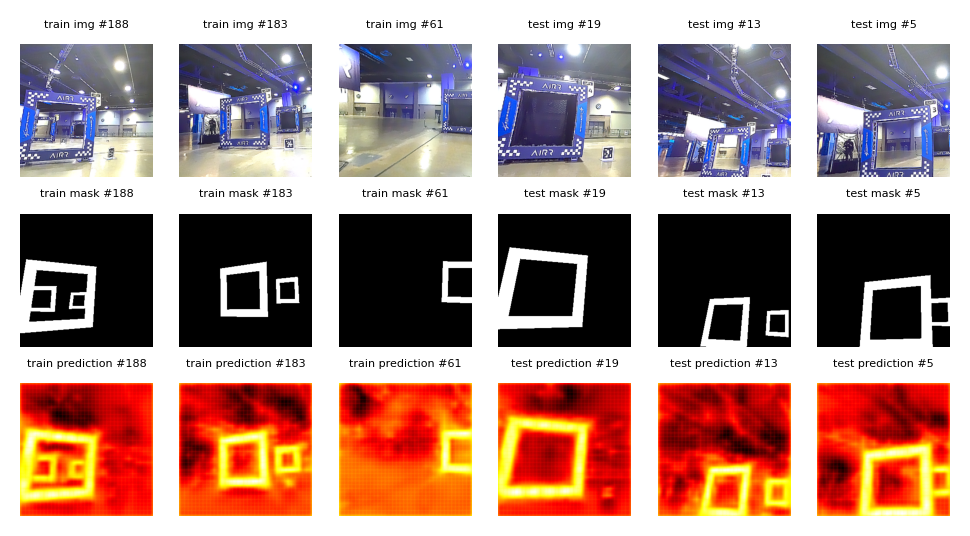

In [ ]:
def gate_detect_init(vgg_config, upsample_mode, batch_norm, print_summary=False, pretrained=True):
    return GateDetection(vgg_config=vgg_config, upsample_mode=upsample_mode,
                                batch_norm=batch_norm, num_epoch=1000,
                                train_set=train_set, test_set=test_set,
                                train_loader=train_loader, test_loader=test_loader,
                                print_summary=print_summary, pretrained=pretrained)

#gate_detection.train()
gate_detection = gate_detect_init('vgg-5', '8s', False)
gate_detection.demo_show(apply_sigmoid=False)
#gate_detection.inference_speed()

### 3.2 Evaluation Experiments
In evaluation experiments, mean intersection of union and pixel prediction accuracy are calculated for all trained models. Inference speeds are also compared.


In [ ]:
vgg_configs = ['vgg-5', 'vgg-11']
upsample_modes = ['32s', '16s', '8s']
batch_norms = [False, True]

logger_eval = open(PROJECT_PATH + "logs/eval_IoU_PA_inference.csv", 'w+')
logger_eval.write("Models,IoU,Pixel Acc.,Inference Speed (ms)\n")
logger_eval.flush()

for upsample_mode in upsample_modes:
        for batch_norm in batch_norms:
            for vgg_config in vgg_configs:
                pretrained_model_path = os.path.join(PROJECT_PATH,
                                                  "pretrained_models/{}_{}_bn_{}".format(vgg_config,
                                                                                         upsample_mode,
                                                                                         str(batch_norm)))
                if os.path.exists(pretrained_model_path):
                    gate_detection = gate_detect_init(vgg_config, upsample_mode, batch_norm)
                    accuracy = gate_detection.compute_IoU_PixelAccuracy()
                    inference_speed = gate_detection.inference_speed()
                    
                    label = '{}-{}-bn'.format(vgg_config, upsample_mode) if batch_norm \
                        else '{}-{}'.format(vgg_config, upsample_mode)
                    logger_eval.write("{}, {}, {}, {}\n".format(label,
                                                                accuracy['IoU'],
                                                                accuracy['PA'],
                                                                inference_speed))
                    logger_eval.flush()

logger_eval.close()

# demonstrate evaluation results
eval_frame = pd.read_csv(PROJECT_PATH + "logs/eval_IoU_PA_inference.csv")
print(eval_frame)

          Models       IoU  Pixel Acc.  Inference Speed (ms)
0      vgg-5-32s  0.704255    0.831855              1.144128
1     vgg-11-32s  0.690630    0.818168              1.385050
2  vgg-11-32s-bn  0.693940    0.781666              2.166442
3      vgg-5-16s  0.872186    0.941183              1.385169
4     vgg-11-16s  0.876680    0.944988              1.454915
5  vgg-11-16s-bn  0.884070    0.945440              2.270545
6       vgg-5-8s  0.910764    0.956274              1.386455
7      vgg-11-8s  0.909926    0.955466              1.725452
8   vgg-11-8s-bn  0.915794    0.957654              2.439550


### 3.3 How Variant FCN Skip-Layer Structures Affect Final Prediction?

This section demonstrates several outputs from models with different FCN architectures. Compared with ground truth and original images, it can be found that FCN-8s, which performs slightly better than FCN-16s, outperforms FCN-32s at gate detection task. This phenomenon indicates that skip-layer structure is essential in predicting the gate positions accurately.

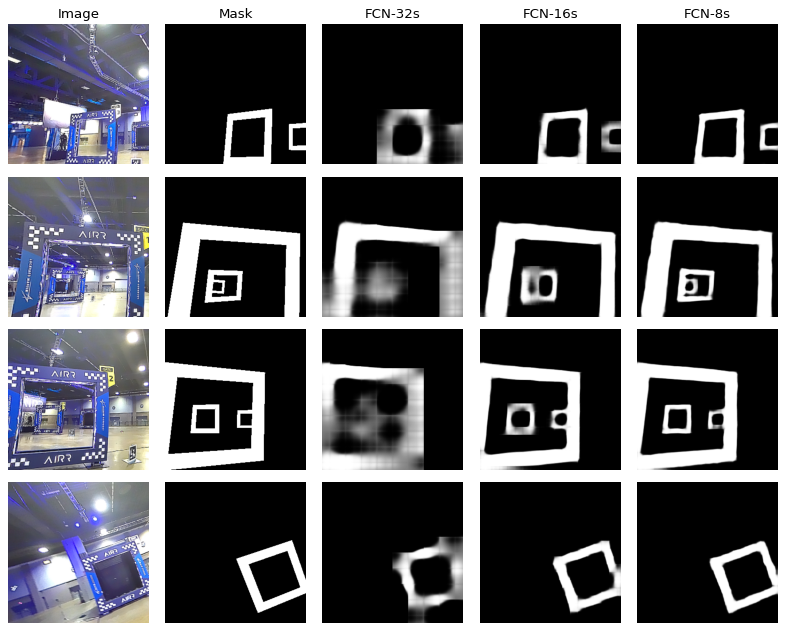

In [ ]:
def show_prediction(apply_sigmoid=True):
    """
    Demonstrate the original image & ground truth & prediction
    on several samples randomly sampled from training/test datasets.
    """
    # plot images and masks
    num_of_subs = 4
    font_size = 20
    sample_seed = np.random.randint(low=1, high=len(test_set), size=int(num_of_subs))
    
    gate_detection_32s = gate_detect_init('vgg-11', '32s', False)
    gate_detection_16s = gate_detect_init('vgg-11', '16s', False)
    gate_detection_8s = gate_detect_init('vgg-11', '8s', False)

    plt.figure(dpi=80, figsize=(10, 8))
    for id, i in enumerate(sample_seed):
        # pick a sample from test dataset
        sample = test_set[i]

        # show original img
        ax1 = plt.subplot(num_of_subs, 5, 5 * id + 1)
        if id == 0:
            ax1.set_title('Image', fontsize=font_size)
        ax1.axis('off')
        original_img = sample['img']
        ax1.imshow(original_img.numpy().transpose(1,2,0))

        # show ground truth
        ax2 = plt.subplot(num_of_subs, 5, 5 * id + 2)
        if id == 0:
            ax2.set_title('Mask', fontsize=font_size)
        ax2.axis('off')
        ground_truth = sample['mask']
        ax2.imshow(ground_truth.numpy().squeeze(0), cmap='gist_gray')

        # show output 32s
        ax3 = plt.subplot(num_of_subs, 5, 5 * id + 3)
        if id == 0:
            ax3.set_title('FCN-32s', fontsize=font_size) 
        ax3.axis('off')

        output = gate_detection_32s.fcn_model(sample['img'].to(gate_detection_32s.device).unsqueeze(0))
        if apply_sigmoid == True:
            output = torch.sigmoid(output)
        ax3.imshow(output.detach().cpu().numpy().reshape(288,288), cmap='gist_gray')

        # show output 16s
        ax4 = plt.subplot(num_of_subs, 5, 5 * id + 4)
        if id == 0:
            ax4.set_title('FCN-16s', fontsize=font_size)
        ax4.axis('off')

        output = gate_detection_16s.fcn_model(sample['img'].to(gate_detection_16s.device).unsqueeze(0))
        if apply_sigmoid == True:
            output = torch.sigmoid(output)
        ax4.imshow(output.detach().cpu().numpy().reshape(288,288), cmap='gist_gray')

        # show output 8s
        ax5 = plt.subplot(num_of_subs, 5, 5 * id + 5)
        if id == 0:
            ax5.set_title('FCN-8s', fontsize=font_size)
        ax5.axis('off')

        output = gate_detection_8s.fcn_model(sample['img'].to(gate_detection_8s.device).unsqueeze(0))
        if apply_sigmoid == True:
            output = torch.sigmoid(output)
        ax5.imshow(output.detach().cpu().numpy().reshape(288,288), cmap='gist_gray')

    plt.tight_layout()
    plt.subplots_adjust(hspace=0.02, wspace=0.01)
    plt.savefig(PROJECT_PATH+'figures/demo_predictions.png')

if __name__ == '__main__':
    show_prediction()

## 4. Conclusion

In this project, a FCN-based gate semantic segmentation neural network model for drone racing is formulated. It can be shown that skip-layer structure plays an essential role in making accurate predictions especially for small gates by focusing on local areas while respecting the global structure. Further work can be done on exploring other network structures like `Resnets` and other upsampling methods.